In [1]:
import pyvisa as vi

In [2]:
import sys
import matplotlib.pyplot as plt
from importlib import reload
reload(sys)
import time
#sys.setdefaultencoding('utf8')
#sys.setdefaultencoding("utf-8")

In [3]:
import numpy as np

In [4]:
rm = vi.ResourceManager()
print(rm.list_resources())

('USB0::0xF4EC::0xEE3A::T0101C20360610::INSTR', 'TCPIP0::172.16.23.200::DSO::INSTR', 'TCPIP0::172.16.1.10::inst0::INSTR', 'TCPIP0::rssgs100a114245::hislip0::INSTR', 'TCPIP0::rssgs100a114245::inst0::INSTR', 'ASRL1::INSTR')


In [5]:
dso = rm.open_resource("USB0::0xF4EC::0xEE3A::T0101C20360610::INSTR")
print(dso.query("*IDN?"))

*IDN  ,T3DSO2304,T0101C20360610,1.2.2.2 R19



In [6]:
%%time

vdiv_strg = dso.query("c1:vdiv?")
print(vdiv_strg)
ofst_strg = dso.query("c1:ofst?")
print(ofst_strg)
tdiv_strg = dso.query("tdiv?")
print(tdiv_strg)
sara_strg = dso.query("sara?")
print(sara_strg)

vdiv = float(vdiv_strg.replace('C1:VDIV ', '').replace('V\n', ''))
ofst = float(ofst_strg.replace('C1:OFST ', '').replace('V\n', ''))
tdiv = float(tdiv_strg.replace('TDIV ', '').replace('S\n', ''))
sara = float(sara_strg.replace('SARA ', '').replace('GSa/s\n', 'e+09').replace('MSa/s\n', 'e+06').replace('kSa/s\n', 'e+03'))


C1:VDIV 5.00E-01V

C1:OFST -1.45E+00V

TDIV 5.00E-07S

SARA 2.00GSa/s

Wall time: 4.01 ms


In [7]:
sara

2000000000.0

In [90]:
%%time

dso.timeout = 5000 #default value is 2000(2s)
dso.chunk_size = 20*1024#*1024 #default value is 20*1024(20k bytes)

In [93]:
dso.write("TRMD SINGLE")

13

In [203]:
dso.write("WFSU SP,10")

12

In [204]:
dso.query("SANU? C1")

'SANU 7kpts\n'

In [205]:
dso.write("ARM")

5

In [206]:
dso.query("INR?")

'INR 8193\n'

In [207]:
x = dso.query("SAST?")

In [208]:
x

'SATA Ready\n'

**************Wall time: 1.99 s


Text(0, 0.5, 'Amplitude [V]')

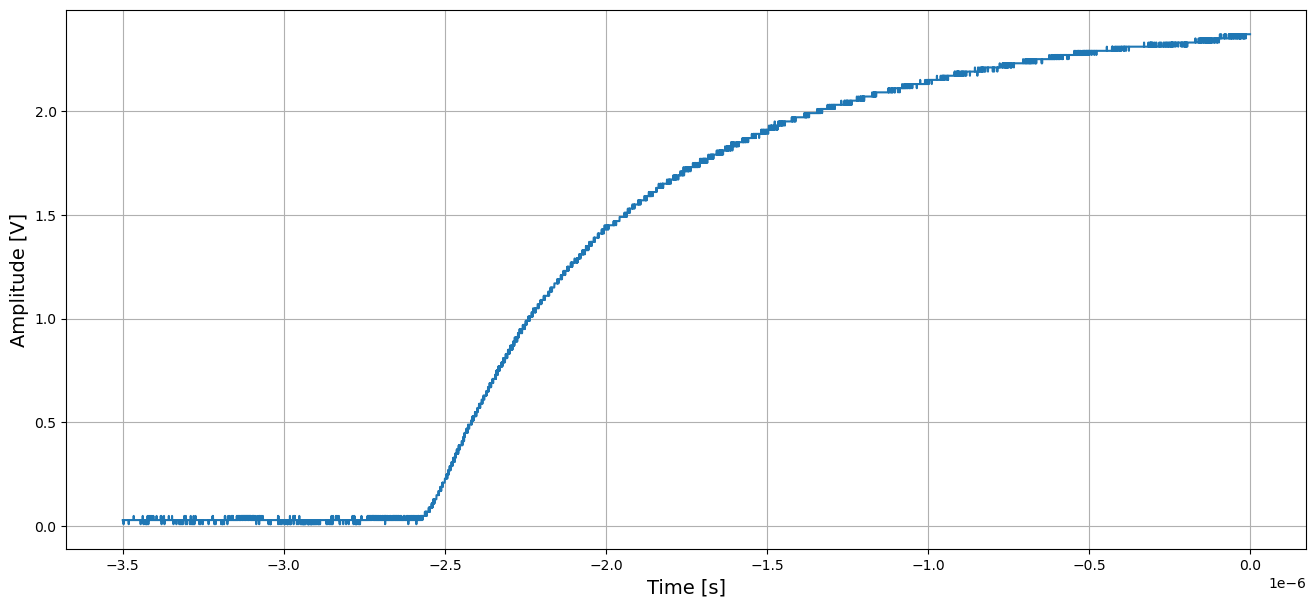

In [226]:
%%time

dso.write("WFSU SP,0")

dso.write("ARM")

#x = dso.query("SAST?")

while True:
    x = dso.query("SAST?")
    print('*', end='')
    if x == 'SATA Stop\n':
        break
    else:
        time.sleep(0.1)
    

time.sleep(0.1)
dso.write("c1:wf? dat2")

raw = dso.read_raw()
recv = list(raw)

len(recv)

recv = np.array(recv)
datac = (recv>127)*(recv-255) + (recv<=127)*recv 
datac = datac[22:-2]

#plt.plot(datac)
#plt.grid()

time_value = []
volt_value = []
for idx in range(0,len(datac)):
    volt_value.append(datac[idx]/25*vdiv-ofst)
    time_value.append(idx*(1/sara) - tdiv*14/2)

#%matplotlib widget

fig = plt.figure(figsize=(16, 7))

plt.plot(time_value, volt_value)
plt.grid()
plt.xlabel('Time [s]', size=14)
plt.ylabel('Amplitude [V]', size=14)
#plt.xlim(180,2000)
#plt.ylim(-0.1, 0.1)